# Shear bias simple test 1

If we have identically zero shape noise, then we only need one galaxy to measure the shear.

A simple validation of shear bias is then to simulate sheared galaxy images with different applied shears and make the measured vs input shear plot and regression. If this doesn't work, then there's a fundamental bug. 


**Simulation procedure:**
1. Make a galaxy image with zero intrinsic ellipticity
2. Shear the image
3. Plot the shear component 1D conditional and marginal posteriors
4. Calculate the shear component marginal posterior constraints
5. Repeat steps 1-4 with different applied shears
6. Repeat steps 1-5 with different SNRs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import galsim

In [238]:
HLR = 1.0
PSF = galsim.Kolmogorov(fwhm=0.6)
scale = 0.2
nx = ny = 64
# var = 3e-7  # Approximately SNR of 100
var = 3e-9
noise = galsim.GaussianNoise(sigma=np.sqrt(var))

In [239]:
def make_data(e1, e2, nu=0.5):
    gal = galsim.Spergel(nu, half_light_radius=HLR)
    obj = galsim.Convolve(PSF, gal)
    obj = obj.shear(galsim.Shear(e1=e1, e2=e2))
    img = obj.drawImage(nx=nx, ny=ny, scale=scale)
    img.addNoise(noise)    
    return img

In [240]:
def lnlike1(e1, e2, nu=0.5):
    gal = galsim.Spergel(nu, half_light_radius=HLR)
    obj = galsim.Convolve(PSF, gal)
    obj = obj.shear(galsim.Shear(e1=e1, e2=e2))
    model = obj.drawImage(nx=nx, ny=ny, scale=scale)
    delta = (model.array - img.array)**2
    lnnorm = - 0.5 * nx * ny * np.sqrt(var * 2 * np.pi)
    return -0.5*np.sum(delta / var) + lnnorm

In [241]:
def ln_gaus(x, a, x0, sigma):
    return a - 0.5 * (x - x0)**2 / sigma**2
    
def fit_gaussian(dat_x, dat_y):
    from scipy.optimize import curve_fit

    p0 = [-100, 0., 0.001]

    popt, pcov = curve_fit(ln_gaus, dat_x, dat_y, p0=p0)
    return popt, pcov

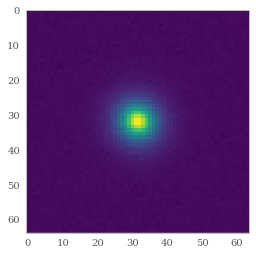

In [242]:
g2 = 0.05

img = make_data(e1=0.0, e2=g2, nu=0.5)
plt.imshow(img.array, interpolation='none', cmap=plt.cm.viridis)

[ 0.04775932  0.00206167]
shear bias: -2.241e-03 +/- 2.062e-03


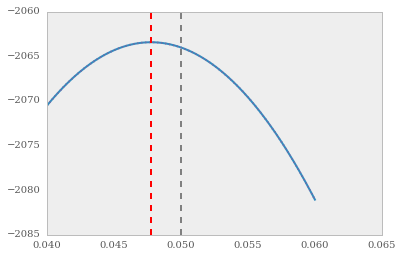

In [244]:
g = np.linspace(g2 - 0.01, g2 + 0.01, 200)
lnp = np.array([lnlike1(e1=0.0, e2=g_val, nu=0.5) for g_val in g])

popt, pcov = fit_gaussian(g, lnp)
print popt[1:3]

print "shear bias: {:4.3e} +/- {:4.3e}".format(popt[1] - g2, popt[2])

plt.plot(g, lnp)
plt.plot(g, ln_gaus(g, popt[0], popt[1], popt[2]), linestyle='dotted')
plt.axvline(g2, color='grey', linestyle='dashed')
plt.axvline(g[np.argmax(lnp)], color='red', linestyle='dashed')

In [245]:
g_true = np.linspace(-0.1, 0.1, 50)
g = np.linspace(g2 - 0.01, g2 + 0.01, 200)

bias = np.zeros((len(g_true), 2), dtype=np.float64)
for i, gt in enumerate(g_true):
    if np.mod(i, 5) == 0:
        print "--- {:d} / {:d} ---".format(i, len(g_true))
    img = make_data(e1=0.0, e2=gt, nu=0.5)
    lnp = np.array([lnlike1(e1=0.0, e2=g_val, nu=0.5) for g_val in g])
    popt, pcov = fit_gaussian(g, lnp)
    bias[i, 0] = popt[1] - gt
    bias[i, 1] = popt[2]

--- 0 / 50 ---
--- 5 / 50 ---
--- 10 / 50 ---
--- 15 / 50 ---
--- 20 / 50 ---
--- 25 / 50 ---
--- 30 / 50 ---
--- 35 / 50 ---
--- 40 / 50 ---
--- 45 / 50 ---


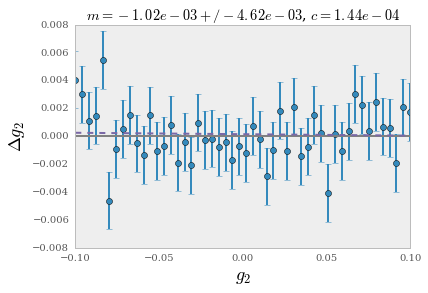

In [246]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(g_true, bias[:,0])
xl = np.linspace(np.min(g_true), np.max(g_true), 50)

plt.errorbar(g_true, bias[:,0], yerr=bias[:,1], fmt='o')
plt.axhline(0., color='grey')
plt.plot(xl, slope*xl + intercept, '--')
plt.xlabel(r"$g_2$", fontsize=18)
plt.ylabel(r"$\Delta g_{:d}$".format(2), fontsize=18)
plt.xlim(-0.1, 0.1)
plt.title(r"$m = {:3.2e} +/- {:3.2e}$, $c = {:3.2e}$".format(slope, std_err, intercept))